In [1]:
import popsims
import numpy as np
import matplotlib.pyplot as plt
import wisps
import pandas as pd
import wisps.simulations as wispsim
from tqdm import tqdm 
import astropy.units as u
import numba
%matplotlib inline

Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database


In [2]:
thin_points=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
names=[x.name for x in thin_points]
volumes=pd.read_pickle(wisps.OUTPUT_FILES+'/thick_disk_volumes.pkl')
DATA=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut_thick_disk.h5',\
     key=str('baraffe2003')+'F110_corrected')
THIN_DATA=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut_binaries.h5',\
                       key=str('baraffe2003')+str(350)+str('spt_abs_mag'))
DISTS=pd.read_pickle(wisps.OUTPUT_FILES+'/thick_disk_distances.pkl')

In [3]:
tot_volumes=abs(np.nansum([[volumes[s][k] for k in  names] for s in wispsim.SPGRID], axis=1))

In [4]:
AREA=4.1*(u.arcmin**2).to(u.radian**2)

[None, Text(0, 0.5, 'volume (kpc$^3$)')]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


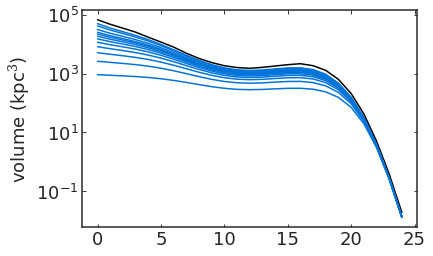

In [5]:
fig, ax=plt.subplots()
plt.plot(tot_volumes*AREA, color='k')
for hidx in thin_points[0].volumes.keys():
    thin_volumes=np.nansum([[x.volumes[hidx][s] for x in thin_points] \
                            for s in wispsim.SPGRID], axis=1)
    plt.plot(thin_volumes*AREA, color='#0074D9')
ax.set(yscale='log', ylabel=r'volume (kpc$^3$)')

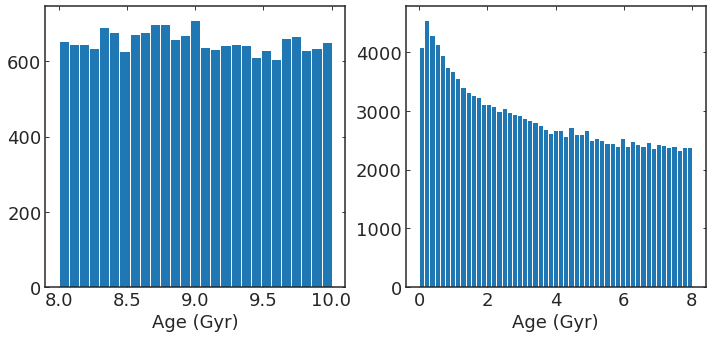

In [6]:
fig, ax=plt.subplots(ncols=2, figsize=(10, 4.5))
h_= ax[0].hist(DATA.age.values,  bins='auto')
h_= ax[1].hist( THIN_DATA.age.values[~THIN_DATA.is_cut],  bins='auto')
plt.tight_layout()
for a in ax:
    a.set(xlabel='Age (Gyr)')


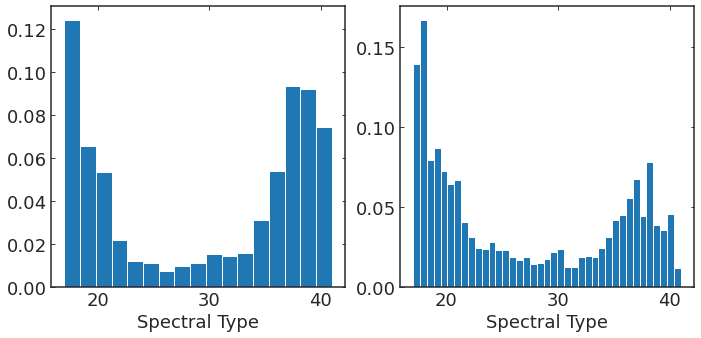

In [7]:
fig, ax=plt.subplots(ncols=2, figsize=(10, 4.5))
h_= ax[0].hist(DATA.spt.values,  bins='auto', density=True)
h_= ax[1].hist( THIN_DATA.spt.values[~THIN_DATA.is_cut],  bins='auto', density=True)
plt.tight_layout()
for a in ax:
    a.set(xlabel='Spectral Type')



In [8]:
 #THIN_DATA.columns

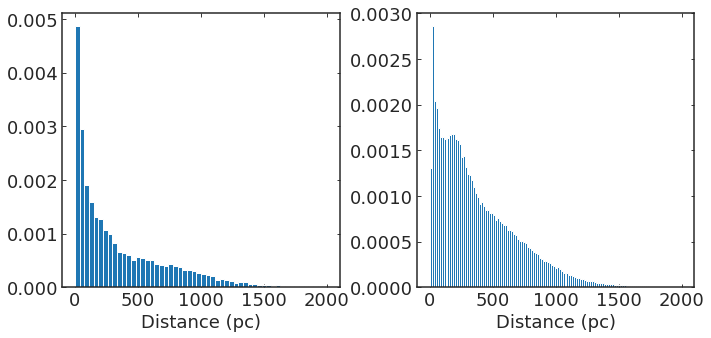

In [9]:
fig, ax=plt.subplots(ncols=2, figsize=(10, 4.5))
h_= ax[0].hist(DATA.dist.values,  bins='auto', density=True, range=[0,2000])
h_= ax[1].hist( THIN_DATA.dist.values[~THIN_DATA.is_cut],  bins='auto', density=True, \
               range=[0, 2000])
plt.tight_layout()

for a in ax:
    a.set(xlabel='Distance (pc)')


In [10]:
def get_simulated_number_model(df):
    cutdf=df.rename(columns={'temperature': 'teff', \
                                          'slprob': 'sl'})

    scale=[cutdf.scale.mean(), cutdf.scale_unc.mean(), cutdf.scale_times_model.mean()]
    
    NSIM=dict(zip(wispsim.SPGRID,np.zeros((len(wispsim.SPGRID), 2))))
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        sn= len(cutdf.teff[np.logical_and(cutdf.teff>=450, cutdf.teff<=2100)])
        n0=scale[-1]/scale[0]
        #print (n0)
        scln=np.array([scale[0]*n0/sn,\
                       (scale[1]*scale[-1])/(sn*scale[0])])
        #scln=np.array(scale)
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].sl)*scln
    del cutdf
    return NSIM

def bin_by_spt_bin(sp_types, number, ltonly=False):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    if ltonly:
        ranges=[[17, 20], [20, 30], [30, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

In [11]:
nexpct_dict=get_simulated_number_model(DATA)
tot_volumes_dict=dict(zip( wispsim.SPGRID, tot_volumes ))

In [30]:
nbers=np.array([nexpct_dict[k][0]*tot_volumes_dict[k]*AREA*0.05 for k in wispsim.SPGRID])

In [31]:
dict(zip( wispsim.SPGRID, nbers))

{17: 4.853286337811056,
 18: 7.970447357486792,
 19: 3.1249876900929685,
 20: 1.9379288426886996,
 21: 1.0346568620789078,
 22: 0.2860658425170653,
 23: 0.136802967045673,
 24: 0.0802522146995487,
 25: 0.043446432525756445,
 26: 0.02142949607513827,
 27: 0.023707891345501584,
 28: 0.02125908703960679,
 29: 0.02275266479515506,
 30: 0.03832947642316808,
 31: 0.026060031437227633,
 32: 0.04239809850219314,
 33: 0.043254542320638946,
 34: 0.05090298189594238,
 35: 0.060893731180672685,
 36: 0.047242492317476376,
 37: 0.023942439394850332,
 38: 0.005039402596220465,
 39: 0.0005274337373726679,
 40: 9.080313047367338e-06,
 41: 0.0}

In [32]:
bin_by_spt_bin(wispsim.SPGRID, nbers)

[15.948721385390817,
 3.4757067290298944,
 0.13259557178115816,
 0.20094513057917018,
 0.1376454992265925]

In [33]:
THIN_DATA.columns

Index(['mass', 'age', 'temperature', 'luminosity', 'is_binary', 'spt',
       'prim_spt', 'sec_spt', 'pri_mass', 'sec_mass', 'prim_luminosity',
       'sec_luminosity', 'scale', 'scale_unc', 'scale_times_model', 'dist',
       'pntname', 'pnt', 'exp_image', 'exp_grism', 'absF110', 'prim_absF110',
       'sec_absF110', 'appF110', 'appF110er', 'absF140', 'prim_absF140',
       'sec_absF140', 'appF140', 'appF140er', 'absF160', 'prim_absF160',
       'sec_absF160', 'appF160', 'appF160er', 'snrj110', 'snrj140', 'snrjs160',
       'snrj', 'slprob', 'is_cut'],
      dtype='object')

In [15]:
#len(tot_volumes), len(wispsim.SPGRID)

In [16]:
#np.nanstd(df.to_pandas().col65)

In [19]:
#np.nanmax(df.to_pandas().col65)

In [ ]:
np.nanmin(df.to_pandas().col65)